In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append("../tutorials")
from utils import score_predictions
import pandas as pd
import ujson as json
import jsonlines
from tqdm import tqdm
from collections import defaultdict
from IPython.core.display import display, HTML, Markdown
from bootleg.symbols.entity_symbols import EntitySymbols
from bootleg.symbols.type_symbols import TypeSymbols
from bootleg.symbols.kg_symbols import KGSymbols
def printmd(string):
    display(Markdown(string))
tqdm.pandas()
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_colwidth = 500
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5000)

In [3]:
def accuracy(df, crc_col="gold_qid", pred_col="pred_qid"):
    total = df.shape[0]
    correct = df[df[crc_col] == df[pred_col]].shape[0]
    return correct/total

def get_incorrect(df, crc_col="gold_qid", pred_col="pred_qid"):
    return df[df[crc_col] != df[pred_col]]

def num_incorrect(df, crc_col="gold_qid", pred_col="pred_qid"):
    return df[df[crc_col] != df[pred_col]].shape[0]

def print_incorrect_over_total(df, crc_col="gold_qid", pred_col="pred_qid"):
    num_in = df[df[crc_col] != df[pred_col]].shape[0]
    total = df.shape[0]
    print(f"{num_in} / {total} = {num_in/total}")

def errors_by_type(df, type_sys, pred_col="pred_qid"):
    errors_type = defaultdict(int)
    df["correct"] = df["gold_qid"] == df[pred_col]
    for r in df.iterrows():
        row = r[1]
        if row.correct is True:
            continue
        for t in row[type_sys]:
            errors_type[t] += 1
    return errors_type

In [ ]:
input_dir = '/dfs/scratch0/lorr1/projects/bootleg/data/wiki_0906_pg/'
emb_dir = '/dfs/scratch0/lorr1/projects/bootleg/embs'
entity_dump = EntitySymbols(load_dir=os.path.join(input_dir, "entity_db/entity_mappings"))
types_hy = TypeSymbols(entity_dump, emb_dir, max_types=3, type_vocab_file="hyena_vocab.json", type_file="hyena_types_0905.json")
types_wd = TypeSymbols(entity_dump, emb_dir, max_types=3, type_vocab_file="wikidata_to_typeid_0905.json", type_file="wikidata_types_0905.json")
types_rel = TypeSymbols(entity_dump, emb_dir, max_types=50, type_vocab_file="relation_to_typeid_0905.json", type_file="kg_relation_types_0905.json")
kg_syms = KGSymbols(entity_dump, emb_dir, "kg_adj_0905.txt")
wdtypes2title = json.load(open(os.path.join(emb_dir, "wikidatatypeid_to_title_0905.json")))
a2q = json.load(open(os.path.join(input_dir, "entity_db/entity_mappings/alias2qids.json")))

Loading types from /dfs/scratch0/lorr1/projects/bootleg/embs/hyena_types_0905.json


Reading /dfs/scratch0/lorr1/projects/bootleg/embs/hyena_types_0905.json: 100%|██████████| 5310039/5310039 [00:23<00:00, 224111.67it/s]


Loading types from /dfs/scratch0/lorr1/projects/bootleg/embs/wikidata_types_0905.json


Reading /dfs/scratch0/lorr1/projects/bootleg/embs/wikidata_types_0905.json: 100%|██████████| 5310039/5310039 [00:21<00:00, 245968.81it/s]


Loading types from /dfs/scratch0/lorr1/projects/bootleg/embs/kg_relation_types_0905.json


Reading /dfs/scratch0/lorr1/projects/bootleg/embs/kg_relation_types_0905.json: 100%|██████████| 5310039/5310039 [00:19<00:00, 271203.69it/s]


Loading kg adj from /dfs/scratch0/lorr1/projects/bootleg/embs/kg_adj_0905.txt


 91%|█████████▏| 23496085/25730507 [01:38<00:07, 282922.85it/s]

In [ ]:
# qid2cnt = defaultdict(int)
# with jsonlines.open(os.path.join(input_dir, "train.jsonl")) as in_f:
#     for line in in_f:
#         for qid in line["qids"]:
#             qid2cnt[qid] += 1
# qid2cnt = dict(qid2cnt)
# with open(os.path.join(input_dir, "train_qidcnt.json"), "w") as out_f:
#     json.save(qid2cnt, out_f)

In [ ]:
with open(os.path.join(input_dir, "train_qidcnt.json"), "r") as in_f:
    qid2cnt = json.load(in_f)

In [7]:
kg_df = pd.read_pickle("./kg_mod1_pg.pkl")
type_df = pd.read_pickle("./type_mod1_pg.pkl")
entity_df = pd.read_pickle("./ent_mod1_pg.pkl")
bert_df = pd.read_pickle("./bert_mod1_pg.pkl")
boot_df = pd.read_pickle("./boot_mod1_pg.pkl")

In [51]:
# Fill in the prediction file generated from mode dump_preds
pred_file = '/dfs/scratch0/lorr1/data/bootleg/bootleg-internal/runs/ablations_0929/kg_only/20200929_043739/merged_dump2/eval/model1/bootleg_labels.jsonl'

kg_df = score_predictions(orig_file=f'{input_dir}/merged_dump_sliced.jsonl', 
                 pred_file=pred_file,
                 entity_mapping_dir=os.path.join(input_dir, "entity_db/entity_mappings"),
                 cands_map=a2q,
                 type_symbols=[types_hy, types_wd, types_rel],
                 kg_symbols=[kg_syms])


100%|██████████| 1512457/1512457 [18:22<00:00, 1372.12it/s]


In [54]:

pred_file = '/dfs/scratch0/lorr1/data/bootleg/bootleg-internal/runs/ablations_0929/type_only/20200929_054939/merged_dump2/eval/model1/bootleg_labels.jsonl'

type_df = score_predictions(orig_file=f'{input_dir}/merged_dump_sliced.jsonl', 
                 pred_file=pred_file,
                 entity_mapping_dir=os.path.join(input_dir, "entity_db/entity_mappings"),
                 cands_map=a2q,
                 type_symbols=[types_hy, types_wd, types_rel],
                 kg_symbols=[kg_syms])

100%|██████████| 1512457/1512457 [24:06<00:00, 1045.42it/s] 


In [53]:

pred_file = '/dfs/scratch0/lorr1/data/bootleg/bootleg-internal/runs/ablations_0929/entity_only/20200929_054930/merged_dump2/eval/model1/bootleg_labels.jsonl'

entity_df = score_predictions(orig_file=f'{input_dir}/merged_dump_sliced.jsonl', 
                 pred_file=pred_file,
                 entity_mapping_dir=os.path.join(input_dir, "entity_db/entity_mappings"),
                 cands_map=a2q,
                 type_symbols=[types_hy, types_wd, types_rel],
                 kg_symbols=[kg_syms])

100%|██████████| 1512457/1512457 [18:28<00:00, 1364.52it/s]


In [49]:
pred_file = '/dfs/scratch0/lorr1/data/bootleg/bootleg-internal/runs/ablations_0929/baseline/20200929_064144/merged_dump2/eval/model1/bootleg_labels.jsonl'

bert_df = score_predictions(orig_file=f'{input_dir}/merged_dump_sliced.jsonl', 
                 pred_file=pred_file,
                 entity_mapping_dir=os.path.join(input_dir, "entity_db/entity_mappings"),
                 cands_map=a2q,
                 type_symbols=[types_hy, types_wd, types_rel],
                 kg_symbols=[kg_syms])

100%|██████████| 1512457/1512457 [23:26<00:00, 1075.00it/s]  


In [ ]:

pred_file = '/dfs/scratch0/lorr1/data/bootleg/bootleg-internal/runs/ablations_0929/bootleg_base_reg/20201013_063228/merged_dump_sliced/eval/model1/bootleg_labels.jsonl'

boot_df = score_predictions(orig_file=f'{input_dir}/merged_dump_sliced.jsonl', 
                 pred_file=pred_file,
                 entity_mapping_dir=os.path.join(input_dir, "entity_db/entity_mappings"),
                 cands_map=a2q,
                 type_symbols=[types_hy, types_wd, types_rel],
                 kg_symbols=[kg_syms])

In [ ]:
boot_df.to_pickle("./boot_mod1_pg.pkl")

In [9]:
res = pd.merge(entity_df, kg_df[['alias_idx', 'sent_idx', 'pred_qid', 'pred_title', 'wikidata_types_0905_pred', 'hyena_types_0905_pred', 'kg_relation_types_0905_pred', 'kg_adj_0905_pred']], on=['alias_idx', 'sent_idx'], suffixes=['', '_kg'])
res = pd.merge(res, type_df[['alias_idx', 'sent_idx', 'pred_qid', 'pred_title', 'wikidata_types_0905_pred', 'hyena_types_0905_pred', 'kg_relation_types_0905_pred', 'kg_adj_0905_pred']], on=['alias_idx', 'sent_idx'], suffixes=['', '_type'])
res = pd.merge(res, boot_df[['alias_idx', 'sent_idx', 'pred_qid', 'pred_title', 'wikidata_types_0905_pred', 'hyena_types_0905_pred', 'kg_relation_types_0905_pred', 'kg_adj_0905_pred']], on=['alias_idx', 'sent_idx'], suffixes=['', '_boot'])
res = pd.merge(res, bert_df[['alias_idx', 'sent_idx', 'pred_qid', 'pred_title', 'wikidata_types_0905_pred', 'hyena_types_0905_pred', 'kg_relation_types_0905_pred', 'kg_adj_0905_pred']], on=['alias_idx', 'sent_idx'], suffixes=['', '_bert'])
print(res.columns, res.shape)

res['is_tail'] = res['slices'].apply(lambda x: 'unif_TL' in x)
res['is_toes'] = res['slices'].apply(lambda x: 'unif_TS' in x)
res['is_torso'] = res['slices'].apply(lambda x: 'unif_TO' in x)
res["num_cands"] = res["cands"].apply(lambda x: len(x))
res["qid_cnt"] = res["gold_qid"].apply(lambda x: qid2cnt.get(x, 0))

res = res[(res["is_gold_label"]) & (res["num_cands"] > 1)]

tail = res[(res['is_tail'])]
torso = res[(res['is_torso'])]
toes = res[(res['is_toes'])]

print(tail.shape, toes.shape)

Index(['sentence', 'sent_idx', 'aliases', 'span', 'slices', 'alias',
       'alias_idx', 'is_gold_label', 'gold_qid', 'pred_qid', 'gold_title',
       'pred_title', 'all_gold_qids', 'all_pred_qids', 'all_spans', 'cands',
       'hyena_types_0905_gld', 'hyena_types_0905_pred',
       'wikidata_types_0905_gld', 'wikidata_types_0905_pred',
       'kg_relation_types_0905_gld', 'kg_relation_types_0905_pred',
       'kg_adj_0905_gld', 'kg_adj_0905_pred', 'pred_qid_kg', 'pred_title_kg',
       'wikidata_types_0905_pred_kg', 'hyena_types_0905_pred_kg',
       'kg_relation_types_0905_pred_kg', 'kg_adj_0905_pred_kg',
       'pred_qid_type', 'pred_title_type', 'wikidata_types_0905_pred_type',
       'hyena_types_0905_pred_type', 'kg_relation_types_0905_pred_type',
       'kg_adj_0905_pred_type', 'pred_qid_boot', 'pred_title_boot',
       'wikidata_types_0905_pred_boot', 'hyena_types_0905_pred_boot',
       'kg_relation_types_0905_pred_boot', 'kg_adj_0905_pred_boot',
       'pred_qid_bert', 'pred_

In [120]:
columns = ['sentence', 'sent_idx', 'aliases', 'alias', 'gold_qid', 'gold_title',
        'pred_title_kg', "pred_qid_kg",
         'pred_title_type', "pred_qid_type", 'pred_title_boot',
           'hyena_types_0905_gld', 'wikidata_types_0905_gld',
           'kg_relation_types_0905_gld', 'kg_adj_0905_gld', 'cands']
single_cols = ["sentence", "gold_title", "pred_title", "qid_cnt", "wikidata_types_0905_gld", "kg_relation_types_0905_gld",
               "kg_adj_0905_gld", "wikidata_types_0905_pred", "kg_relation_types_0905_pred", "kg_adj_0905_pred", "cands"]

In [48]:
print("TORSO", accuracy(torso, pred_col="pred_qid"), accuracy(torso, pred_col="pred_qid_type"), accuracy(torso, pred_col="pred_qid_kg"), accuracy(torso, pred_col="pred_qid_boot"), accuracy(torso, pred_col="pred_qid_bert"))
print("TAIL", accuracy(tail, pred_col="pred_qid"), accuracy(tail, pred_col="pred_qid_type"), accuracy(tail, pred_col="pred_qid_kg"), accuracy(tail, pred_col="pred_qid_boot"), accuracy(tail, pred_col="pred_qid_bert"))
print("TOES", accuracy(toes, pred_col="pred_qid"), accuracy(toes, pred_col="pred_qid_type"), accuracy(toes, pred_col="pred_qid_kg"), accuracy(toes, pred_col="pred_qid_boot"), accuracy(toes, pred_col="pred_qid_bert"))

0.3455244170239465 0.5869758444002928 0.603105719962355 0.6505280769632961
0.7919746627198406 0.8013698246870611 0.7819387943528305 0.8605834065435988


# Core Reasoning Patterns

In [62]:
printmd("**Textual Memorization**: Entity specific context is the disambiguating cue.")
sent_i = 33035320
display(boot_df[boot_df["sent_idx"] == sent_i][single_cols])

**Textual Memorization**: Entity specific context is the disambiguating cue.

,sentence,gold_title,pred_title,qid_cnt,wikidata_types_0905_gld,kg_relation_types_0905_gld,kg_adj_0905_gld,wikidata_types_0905_pred,kg_relation_types_0905_pred,kg_adj_0905_pred,cands
215745,"He aided Sun Ce in conquering Lujiang Commandery ( 廬江郡 ) before they crossed the Yangtze River and attacked Hengjiang ( 橫江 ) and Dangli ( 當利 ) , where they defeated Zhang Ying ( 張英 ) and Yu Mi ( 于糜 ) , the subordinates of a rival warlord Liu Yao .",Cheng Pu,Cheng Pu,80,[military personnel],"[cause of death, part of, family name, place of birth, country of citizenship, sex or gender, occupation]",[],[military personnel],"[cause of death, part of, family name, place of birth, country of citizenship, sex or gender, occupation]",[],"[(Jackie Chan, 1.2645099332075915e-06), (Zheng He, 0.000819097098428756), (Yongle Emperor, 0.0006472442764788866), (Chen Cheng, 6.077119905967265e-06), (Sammi Cheng, 4.4639793372880376e-07), (King Cheng of Zhou, 0.004861921072006226), (Ekin Cheng, 2.8115539407735923e-07), (Adam Cheng, 1.5295516675450926e-07), (Murong Chui, 0.12870781123638153), (Emperor Xiaozong of Song, 0.00036728993291035295), (Carol Cheng, 1.391804289596621e-07), (Kevin Cheng, 3.6983908557886025e-07), (Emperor Cheng of Ha..."
215746,"He aided Sun Ce in conquering Lujiang Commandery ( 廬江郡 ) before they crossed the Yangtze River and attacked Hengjiang ( 橫江 ) and Dangli ( 當利 ) , where they defeated Zhang Ying ( 張英 ) and Yu Mi ( 于糜 ) , the subordinates of a rival warlord Liu Yao .",Yangtze,Yangtze,2502,[river],"[lakes on river, bodies of water basin category, origin of the watercourse, topic's main template, basin country, drainage basin, mouth of the watercourse, continent, on focus list of Wikimedia project, tributary, described by source, topic's main category, located in the administrative territorial entity, country]",[],[river],"[lakes on river, bodies of water basin category, origin of the watercourse, topic's main template, basin country, drainage basin, mouth of the watercourse, continent, on focus list of Wikimedia project, tributary, described by source, topic's main category, located in the administrative territorial entity, country]",[],"[(Yangtze, 0.9999995231628418), (Suparna Airlines, 6.118719966252684e-07)]"
215747,"He aided Sun Ce in conquering Lujiang Commandery ( 廬江郡 ) before they crossed the Yangtze River and attacked Hengjiang ( 橫江 ) and Dangli ( 當利 ) , where they defeated Zhang Ying ( 張英 ) and Yu Mi ( 于糜 ) , the subordinates of a rival warlord Liu Yao .",Liu Yao (warlord),Liu Yao,129,[politician],"[family, place of death, family name, place of birth, country of citizenship, sex or gender, occupation]",[],[military personnel],"[mother, spouse, father, sibling, child, position held, country of citizenship, sex or gender, occupation]",[],"[(Emperor Cheng of Han, 0.35843425989151), (Liu Yao, 0.4406382441520691), (Liu Yao (warlord), 0.20092757046222687)]"


In [58]:
printmd("**Type Consistency**: The correct type is the one that is consistent with other conditioned on a type-sequence context cue.")
sent_i = 4421
display(boot_df[boot_df["sent_idx"] == sent_i][single_cols])

**Type Consistency**: The correct type is the one that is consistent with other conditioned on a type-sequence context cue.

,sentence,gold_title,pred_title,qid_cnt,wikidata_types_0905_gld,kg_relation_types_0905_gld,kg_adj_0905_gld,wikidata_types_0905_pred,kg_relation_types_0905_pred,kg_adj_0905_pred,cands
150,"Dewitt Clinton , President William McKinley , Samuel Clemens , Charles Dickens , Henry Clay , Daniel Webster , John L Sullivan and Jenny Lind were all honored guests of the Frontier House .",William McKinley,William McKinley,1992,"[politician, lawyer, statesperson]","[killed by, writing language, native language, mother, military branch, manner of death, cause of death, place of burial, spouse, father, conflict, work location, religion, child, political party, described by source, languages spoken, written or signed, topic's main category, place of death, position held, educated at, family name, place of birth, given name, country of citizenship, sex or gender, occupation]",[],"[politician, lawyer, statesperson]","[killed by, writing language, native language, mother, military branch, manner of death, cause of death, place of burial, spouse, father, conflict, work location, religion, child, political party, described by source, languages spoken, written or signed, topic's main category, place of death, position held, educated at, family name, place of birth, given name, country of citizenship, sex or gender, occupation]",[],"[(William McKinley, 0.9999556541442871), (William McKinley (Virginia), 4.431674460647628e-05)]"
151,"Dewitt Clinton , President William McKinley , Samuel Clemens , Charles Dickens , Henry Clay , Daniel Webster , John L Sullivan and Jenny Lind were all honored guests of the Frontier House .",Charles Dickens,Charles Dickens,3848,"[journalist, writer, author]","[list of works, topic's main Wikimedia portal, permanent duplicated item, unmarried partner, archives at, movement, writing language, on focus list of Wikimedia project, native language, notable work, ethnic group, mother, manner of death, cause of death, place of burial, spouse, father, religion, sibling, child, described by source, languages spoken, written or signed, topic's main category, place of death, award received, family name, place of birth, given name, country of citizenship, sex...",[],"[journalist, writer, author]","[list of works, topic's main Wikimedia portal, permanent duplicated item, unmarried partner, archives at, movement, writing language, on focus list of Wikimedia project, native language, notable work, ethnic group, mother, manner of death, cause of death, place of burial, spouse, father, religion, sibling, child, described by source, languages spoken, written or signed, topic's main category, place of death, award received, family name, place of birth, given name, country of citizenship, sex...",[],"[(Charles Dickens, 1.0)]"
152,"Dewitt Clinton , President William McKinley , Samuel Clemens , Charles Dickens , Henry Clay , Daniel Webster , John L Sullivan and Jenny Lind were all honored guests of the Frontier House .",Henry Clay,Henry Clay,1498,"[politician, lawyer, diplomat]","[place of burial, spouse, work location, religion, member of, child, political party, described by source, languages spoken, written or signed, topic's main category, place of death, position held, educated at, family name, place of birth, given name, country of citizenship, sex or gender, occupation]",[],"[politician, lawyer, diplomat]","[place of burial, spouse, work location, religion, member of, child, political party, described by source, languages spoken, written or signed, topic's main category, place of death, position held, educated at, family name, place of birth, given name, country of citizenship, sex or gender, occupation]",[],"[(Henry Clay, 0.9996867775917053), (Henry Clay (steamboat), 2.846553570634569e-06), (Henry Clay (rower), 4.4265316319069825e-06), (Henry Clay Jr., 0.00028050827677361667), (Henry Clay (cigar), 5.93867116549518e-06), (Henry Clay, Kentucky, 8.616200830147136e-06), (Henry Clay (economist), 4.337634891271591e-07), (Sir Henry Clay, 6th Ba

In [59]:
printmd("**Type Context**: Type specific context determines the correct type for the sentence.")
sent_i = 39187247
display(boot_df[boot_df["sent_idx"] == sent_i][single_cols])

**Type Context**: Type specific context determines the correct type for the sentence.

,sentence,gold_title,pred_title,qid_cnt,wikidata_types_0905_gld,kg_relation_types_0905_gld,kg_adj_0905_gld,wikidata_types_0905_pred,kg_relation_types_0905_pred,kg_adj_0905_pred,cands
694724,"The restaurant was named in honour of Joe Beef , an Irish -born Montreal tavern owner in the 19th century .",Joe Beef,Joe Beef (restaurant),46,"[soldier, restaurateur, innkeeper]","[item operated, residence, owner of, military branch, place of burial, conflict, religion, place of death, family name, place of birth, given name, sex or gender, occupation]",[],[restaurant],"[located in the administrative territorial entity, country]",[],"[(Joe Beef (restaurant), 0.7762696743011475), (Joe Beef, 0.22373026609420776)]"
694725,"The restaurant was named in honour of Joe Beef , an Irish -born Montreal tavern owner in the 19th century .",Ireland,Ireland,23530,[island],"[driving side, geography of topic, category for films shot at this location, topic's main Wikimedia portal, highest point, category of people buried here, category for people who died here, category for maps, located on terrain feature, located in or next to body of water, continent, category of associated people, category for people born here, different from, part of, described by source, topic's main category, located in time zone, country]",[],[island],"[driving side, geography of topic, category for films shot at this location, topic's main Wikimedia portal, highest point, category of people buried here, category for people who died here, category for maps, located on terrain feature, located in or next to body of water, continent, category of associated people, category for people born here, different from, part of, described by source, topic's main category, located in time zone, country]",[],"[(Ireland, 0.5573526620864868), (Republic of Ireland, 0.04035945236682892), (Northern Ireland, 0.0014561587013304234), (Irish people, 0.3803108334541321), (Irish language, 0.0015981574542820454), (United Kingdom of Great Britain and Ireland, 0.0004311146622058004), (Irish Americans, 0.016545522958040237), (Republic of Ireland national football team, 7.292989266716177e-06), (Ireland national rugby union team, 5.656886969518382e-06), (Irish Free State, 0.00029538001399487257), (League of Irela..."


In [65]:
printmd("**KG Relations**: KG relation context determines relationship (plus the addition of the KG pair in the sentence).")
sent_i = 39983508
display(boot_df[boot_df["sent_idx"] == sent_i][single_cols])

**KG Relations**: KG relation context determines relationship (plus the addition of the KG pair in the sentence).

,sentence,gold_title,pred_title,qid_cnt,wikidata_types_0905_gld,kg_relation_types_0905_gld,kg_adj_0905_gld,wikidata_types_0905_pred,kg_relation_types_0905_pred,kg_adj_0905_pred,cands
720085,"The county borders every other Connacht county – Galway , Mayo , Sligo and Leitrim , as well as three Leinster counties – Longford , Westmeath and Offaly .",Connacht,Connacht,1139,[province of Ireland],"[category for maps, category of associated people, category for people born here, described by source, topic's main category, located in time zone, shares border with, located in the administrative territorial entity, country]","[Q169923, Q178626, Q179325, Q107397, Q159736]",[province of Ireland],"[category for maps, category of associated people, category for people born here, described by source, topic's main category, located in time zone, shares border with, located in the administrative territorial entity, country]","[Q169923, Q178626, Q179325, Q107397, Q159736]","[(Connacht, 0.943019688129425), (Connacht Rugby, 0.00016270687046926469), (Connacht GAA, 0.043015386909246445), (List of kings of Connacht, 0.00837367121130228), (Connacht Senior Football Championship, 0.0030568435322493315), (Connachta, 1.109728964365786e-05), (Connacht Senior Club Hurling Championship, 0.0010709307389333844), (Connacht Senior Club Football Championship, 0.00014933441707398742), (Connacht Senior Hurling Championship, 0.00022578454809263349), (Connacht Football Association, ..."
720086,"The county borders every other Connacht county – Galway , Mayo , Sligo and Leitrim , as well as three Leinster counties – Longford , Westmeath and Offaly .",County Galway,Galway GAA,1798,[county of Ireland],"[executive body, legislative body, category for maps, category for people born here, language used, capital, office held by head of government, described by source, contains administrative territorial entity, topic's main category, located in time zone, shares border with, located in the administrative territorial entity, country]","[Q164421, Q178626, Q184445]",[sports organization],"[member of, topic's main category, sport]","[Q164421, Q178626, Q184445]","[(Galway GAA, 0.5335105657577515), (County Galway, 0.4274911880493164), (Galway, 0.03889687359333038), (NUI Galway, 2.4658561414980795e-06), (Galway United F.C., 1.4476568139798474e-06), (James Galway, 1.2795621842087712e-06), (Galway County Council, 8.98675625649048e-06), (Galway Kinnell, 9.516913479501454e-08), (Roman Catholic Diocese of Galway, Kilmacduagh and Kilfenora, 2.674847110029077e-06), (Galway City Council, 3.081702016061172e-05), (Galway Borough (UK Parliament constituency), 8.2..."
720087,"The county borders every other Connacht county – Galway , Mayo , Sligo and Leitrim , as well as three Leinster counties – Longford , Westmeath and Offaly .",County Mayo,County Mayo,1469,[county of Ireland],"[executive body, legislative body, category for maps, category of associated people, category for people born here, language used, capital, twinned administrative body, office held by head of government, described by source, contains administrative territorial entity, topic's main category, located in time zone, shares border with, located in the administrative territorial entity, country]","[Q164421, Q169923, Q179325]",[county of Ireland],"[executive body, legislative body, category for maps, category of associated people, category for people born here, language used, capital, twinned administrative body, office held by head of government, described by source, contains administrative territorial entity, topic's main category, located in time zone, shares border with, located in the administrative territorial entity, country]","[Q164421, Q169923, Q179325]","[(County Mayo, 0.9264536499977112), (Mayo Clinic, 1.054018230206566e-05), (Mayo GAA, 0.0732523575425148), (Virginia Mayo, 1.0706195752163694e-07), (Simon Mayo, 2.413020411040634e-06), (Archie Mayo, 4.364889889529877e-07), (O. J. Mayo, 5.068463337920548e-07), (Divisi

In [122]:
# Conflict
printmd("**Conflict:**")
display(res[(res["pred_qid_type"] != res["pred_qid_kg"]) & (res["pred_qid_type"] == res["gold_qid"]) & (res["kg_adj_0905_pred_kg"].apply(lambda x: len(x)>0))][columns].sample(30))

**Conflict:**

,sentence,sent_idx,aliases,alias,gold_qid,gold_title,pred_title_kg,pred_qid_kg,pred_title_type,pred_qid_type,pred_title_boot,hyena_types_0905_gld,wikidata_types_0905_gld,kg_relation_types_0905_gld,kg_adj_0905_gld,cands
2436816,"In addition , there is newsreel footage of Gershwin playing `` Mademoiselle from New Rochelle '' and `` Strike Up the Band `` on the piano during a Broadway rehearsal of the 1930 production of `` Strike Up the Band '' .",15857790,"[gershwin, strike up the band]",strike up the band,Q7623799,Strike Up the Band (song),Strike Up the Band (musical),Q7623800,Strike Up the Band (song),Q7623799,Strike Up the Band (song),[<wordnet_artifact_100021939>],[song],"[composer, language of work or name, country of origin]",[Q123829],"[(Strike Up the Band (musical), 0.6348341107368469), (Strike Up the Band (film), 0.07627739757299423), (Strike Up the Band (song), 0.26381930708885193), (Strike Up the Band (Tony Bennett and Count Basie album), 0.023613102734088898), (Strike Up the Band, 0.0005548245972022414), (Strike Up the Band (Red Garland album), 0.0009010743233375251)]"
577399,"Initially , Urfa was part of Syria according to the Treaty of Sèvres ; but the success of Turkish War of Independence , Maraş , Antep and Urfa sanjaks of former Halep Eyalet remained in Turkey after 1921 .",46584010,"[urfa, syria, treaty of sevres, turkish war of independence, maras, antep, urfa, halep eyalet]",maras,Q12217004,Marash Sanjak,Kahramanmaraş,Q134703,Marash Sanjak,Q12217004,Marash Sanjak,[<yagoGeoEntity>],[sanjak of the Ottoman Empire],"[located in the administrative territorial entity, country]",[Q1493892],"[(Kahramanmaraş, 0.6020212769508362), (Mara (mammal), 0.11536979675292969), (Anthony Maras, 0.002668812172487378), (Mara (gang), 0.07011406868696213), (Čedo Maras, 0.00015452862135134637), (Robert Maras, 0.0002925616572611034), (Marash Sanjak, 0.05618124082684517), (Maras, Peru, 0.026420312002301216), (Mate Maras, 0.0028328599873930216), (Vlasios Maras, 0.0005705431685782969), (Māras, 0.021263254806399345), (Wiesław Maras, 0.047762319445610046), (Ivan Maraš, 3.060508970520459e-05), (Tommy Ma..."
379210,"Vocalist Kyle Kupecky comments about the meaning behind the name : On February 1 , 2011 , Anthem Lights released the `` Anthem Lights `` EP .",26877936,"[anthem lights, anthem lights]",anthem lights,Q4771585,Anthem Lights (EP),Anthem Lights (album),Q4771586,Anthem Lights (EP),Q4771585,Anthem Lights (EP),"[<wordnet_album_106591815>, <wordnet_medium_106254669>, <wordnet_instrumentality_103575240>]",[extended play],"[performer, record label]",[Q14580455],"[(Anthem Lights (album), 0.8816505670547485), (Anthem Lights, 0.008722711354494095), (Anthem Lights (EP), 0.10962670296430588)]"
3874996,Its habitat is scrubland s bordering salt flat s ( such as those of the Salinas Grandes ) in the Monte Desert area of central western Argentina at elevations around 400 m The closest relatives of the species are the chaco mice ( `` Andalgalomys '' ) .,45038366,"[salt flat, salinas grandes, monte desert, argentina]",salinas grandes,Q1966071,Salinas Grandes,Salinas Grandes (Jujuy and Salta),Q2893104,Salinas Grandes,Q1966071,Salinas Grandes (Jujuy and Salta),"[<wordnet_tract_108673395>, <wordnet_geographical_area_108574314>, <wordnet_area_108497294>]","[lake, beach]","[tributary, country]",[Q414],"[(Salinas Grandes, 0.8146838545799255), (Salinas Grandes (Jujuy and Salta), 0.18531599640846252)]"
1284121,"Derenik-Ashot Artsruni ( , died 958/959 ) was the second King of Vaspurakan , from the Artsruni dynasty , succeeding his father , Gagik I , on the latter 's death .",33710334,"[artsruni, artsruni, artsruni, gagik i]",artsruni,Q714013,Artsruni dynasty,Gagik I Artsruni,Q882866,Artsruni dynasty,Q714013,Artsruni dynasty,"[<wordnet_organization_108008335>, <yagoGeoEntity>]","[noble family, nakhararq]","[ethnic group, owner of, religion, part of, described by source, topic's main category, country]","[Q3045030, Q3045030, Q882866]","[(Artsruni dynasty, 0.254

In [ ]:
# Two hop
printmd("**Two Hop/Granularity**: note that this Ellsworth is the less popular Ellsworth")
sent_i = 9875287
display(boot_df[boot_df["sent_idx"] == sent_i][single_cols])

In [54]:
def two_hop(row):
    if len(row.kg_adj_0905_gld) > 0:
        return False
    if any(sl.startswith("1_wd_aff") or sl.startswith("3_wd_aff_all") for sl in row.slices or sl.startswith("1_cons_") or sl.startswith("3_cons_") for sl in row.slices):
        return False
    qid = row.gold_qid
    for i, qid1 in enumerate(row.all_gold_qids):
        if qid1 == qid:
            continue
        if kg_syms.is_connected(qid, qid1):
            return False
        for connected_qid in kg_syms.qid2connections.get(qid, {}):
            if connected_qid in all_tys or connected_qid == "Q5":
                continue
            if connected_qid in kg_syms.qid2connections.get(qid1, {}):
                return True
    return False

res_errors = res[(res["pred_qid_boot"] != res["gold_qid"])]
tail_errors = tail[(tail["pred_qid_boot"] != tail["gold_qid"])]
temp = res_errors[res_errors.progress_apply(lambda x: two_hop(x), axis=1)]
temp_tail = tail_errors[tail_errors.progress_apply(lambda x: two_hop(x), axis=1)]
print("BOOTLEG ERROR COVERAGE", temp.shape[0], res_errors.shape[0], temp.shape[0]/res_errors.shape[0])
print("BOOTLEG TAIL ERROR COVERAGE", temp_tail.shape[0], tail_errors.shape[0], temp_tail.shape[0]/tail_errors.shape[0])

100%|██████████| 51355/51355 [00:36<00:00, 1421.53it/s]

BOOTLEG ERROR COVERAGE 15604 268258 0.05816788315725906
BOOTLEG TAIL ERROR COVERAGE 3580 51355 0.06971083633531301


In [62]:
temp_tail.sample(5)[["sentence", "sent_idx", "alias_idx", "aliases", "alias", "gold_qid", "pred_qid_boot", "all_gold_qids", "gold_title", "pred_title", "pred_title_type", "pred_title_kg", "pred_title_bert", "pred_title_boot", "wikidata_types_0905_gld", "kg_relation_types_0905_gld"]]

,sentence,sent_idx,alias_idx,aliases,alias,gold_qid,pred_qid_boot,all_gold_qids,gold_title,pred_title,pred_title_type,pred_title_kg,pred_title_bert,pred_title_boot,wikidata_types_0905_gld,kg_relation_types_0905_gld
796474,"In the 2016 elections the party fielded thirteen candidates , winning two seats ; Emelee in Torres and Jack Wona in Banks .",2311828,0,"[2016 elections, banks]",2016 elections,Q22076640,Q21882816,"[Q22076640, Q537817]",2016 Vanuatuan general election,2016 South Korean legislative election,2016 Zambian general election,2016 Tamil Nadu Legislative Assembly election,2016 Dominican Republic general election,2016 Tamil Nadu Legislative Assembly election,[],"[candidate, office contested, applies to jurisdiction, followed by, follows, country]"
220563,The Galway captain was David Burke and Cathal Mannion was named as the man of the match for the replay .,18965240,0,"[david burke, cathal mannion]",david burke,Q5231917,Q17579910,"[Q5231917, Q20745015]",David Burke (Galway hurler),David Burke (Galway hurler),David Burke (Kilkenny hurler),David Burke (Galway hurler),David Burke (Galway hurler),David Burke (Kilkenny hurler),[hurler],"[award received, sport, family name, place of birth, member of sports team, given name, country of citizenship, sex or gender, occupation]"
2698896,"Several Filipino politicians also referenced the AlDub couple in various interviews : Ralph Recto cited the tandem as a symbolism regarding the Philippine Land Transportation Office license plates , while Mar Roxas also referenced AlDub in his 2016 presidential campaign .",22267491,3,"[ralph recto, land transportation office, mar roxas, 2016 presidential campaign]",2016 presidential campaign,Q21190812,Q699872,"[Q555499, Q6484001, Q1396213, Q21190812]",2016 Mar Roxas presidential campaign,Bernie Sanders 2016 presidential campaign,2016 United States presidential election,Donald Trump 2016 presidential campaign,Bernie Sanders 2016 presidential campaign,2016 United States presidential election,[],[country]
2197813,"When the hyperthermophilic archaea `` Sulfolobus solfataricus `` and `` Sulfolobus acidocaldarius `` are exposed to the DNA damaging agents UV irradiation , bleomycin or mitomycin C , species-specific cellular aggregation is induced .",28209777,2,"[hyperthermophilic, sulfolobus solfataricus, sulfolobus acidocaldarius, uv, mitomycin c]",sulfolobus acidocaldarius,Q2364491,Q1209791,"[Q1784119, Q3503466, Q2364491, Q11391, Q417625]",Sulfolobus acidocaldarius,Sulfolobus,Sulfolobus,Sulfolobus,Sulfolobus,Sulfolobus,[taxon],"[taxon rank, parent taxon]"
3951576,"At the end of the night , his fingers were seriously injured and there was blood at his white Giannini .",22096974,2,"[fromer, fromer, giannini]",giannini,Q5558216,Q1522668,"[Q6756553, Q6756553, Q5558216]",Giannini,Giannini Automobili,Giannini Automobili,Giannini,Giannini Automobili,Giannini Automobili,[privately held company],"[product or material produced, legal form, founded by, headquarters location, country]"


In [65]:
sent_idx = 22267491
al_idx = 3
qids = boot_df[(boot_df["sent_idx"] == sent_idx) & (boot_df["alias_idx"] == al_idx)]["all_gold_qids"].item()
print(qids)
qid1 = boot_df[(boot_df["sent_idx"] == sent_idx) & (boot_df["alias_idx"] == al_idx)]["gold_qid"].item()
for qid2 in qids:
    if qid1 == qid2:
        continue
    for connected_qid in kg_syms.qid2connections.get(qid1, {}):
        if connected_qid in kg_syms.qid2connections.get(qid2, {}):
            print("CONNECTED", entity_dump.get_title(qid1), "TO", entity_dump.get_title(qid2), "VIA", connected_qid, entity_dump.get_title(connected_qid))

['Q555499', 'Q6484001', 'Q1396213', 'Q21190812']
CONNECTED 2016 Mar Roxas presidential campaign TO Ralph Recto VIA Q928 Philippines
CONNECTED 2016 Mar Roxas presidential campaign TO Mar Roxas VIA Q928 Philippines


/dfs/scratch0/lorr1/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
/dfs/scratch0/lorr1/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: `item` has been deprecated and will be removed in a future version
  """


In [52]:
temp_ty = json.load(open("/dfs/scratch0/lorr1/projects/bootleg/embs/wikidatatypeid_to_title_0905.json"))
all_tys = temp_ty.keys()
len(all_tys)

26933

In [11]:
import re
def has_year(row):
    return re.match(r'.*([1-3][0-9]{3})', row.gold_title) is not None

res_errors = res[(res["pred_qid_boot"] != res["gold_qid"])]
tail_errors = tail[(tail["pred_qid_boot"] != tail["gold_qid"])]
temp = res_errors[res_errors.progress_apply(lambda x: has_year(x), axis=1)]
temp_tail = tail_errors[tail_errors.progress_apply(lambda x: has_year(x), axis=1)]
print("BOOTLEG ERROR COVERAGE", temp.shape[0], res_errors.shape[0], temp.shape[0]/res_errors.shape[0])
print("BOOTLEG TAIL ERROR COVERAGE", temp_tail.shape[0], tail_errors.shape[0], temp_tail.shape[0]/tail_errors.shape[0])

100%|██████████| 51355/51355 [00:04<00:00, 11552.71it/s]

BOOTLEG ERROR COVERAGE 36523 268258 0.13614878214256423
BOOTLEG TAIL ERROR COVERAGE 12725 51355 0.24778502580079836


In [12]:
import re
def is_subset(args):
    gold_title, pred_title = args
    return f" {pred_title}" in gold_title or f"{pred_title} " in gold_title


res_errors = res[(res["pred_qid_boot"] != res["gold_qid"])]
tail_errors = tail[(tail["pred_qid_boot"] != tail["gold_qid"])]
temp = res_errors[res_errors[["gold_title", "pred_title_boot"]].progress_apply(lambda x: is_subset(x), axis=1)]
temp_tail = tail_errors[tail_errors[["gold_title", "pred_title_boot"]].progress_apply(lambda x: is_subset(x), axis=1)]
print("BOOTLEG ERROR COVERAGE", temp.shape[0], res_errors.shape[0], temp.shape[0]/res_errors.shape[0])
print("BOOTLEG TAIL ERROR COVERAGE", temp_tail.shape[0], tail_errors.shape[0], temp_tail.shape[0]/tail_errors.shape[0])

import re
def is_superset(args):
    gold_title, pred_title = args
    return f" {gold_title}" in pred_title or f"{gold_title} " in pred_title


res_errors = res[(res["pred_qid_boot"] != res["gold_qid"])]
tail_errors = tail[(tail["pred_qid_boot"] != tail["gold_qid"])]
temp = res_errors[res_errors[["gold_title", "pred_title_boot"]].progress_apply(lambda x: is_superset(x), axis=1)]
temp_tail = tail_errors[tail_errors[["gold_title", "pred_title_boot"]].progress_apply(lambda x: is_superset(x), axis=1)]
print("BOOTLEG ERROR COVERAGE", temp.shape[0], res_errors.shape[0], temp.shape[0]/res_errors.shape[0])
print("BOOTLEG TAIL ERROR COVERAGE", temp_tail.shape[0], tail_errors.shape[0], temp_tail.shape[0]/tail_errors.shape[0])

100%|██████████| 51355/51355 [00:02<00:00, 18567.54it/s]


BOOTLEG ERROR COVERAGE 42915 268258 0.15997658970095952
BOOTLEG TAIL ERROR COVERAGE 9412 51355 0.18327329373965534


100%|██████████| 51355/51355 [00:02<00:00, 18407.04it/s]


BOOTLEG ERROR COVERAGE 24143 268258 0.08999917989398266
BOOTLEG TAIL ERROR COVERAGE 3516 51355 0.0684646090935644


In [19]:
import re
def is_type(types):
    return any("geo" in ty for ty in types)


res_errors = res[(res["pred_qid_boot"] != res["gold_qid"])]
tail_errors = tail[(tail["pred_qid_boot"] != tail["gold_qid"])]
temp = res_errors[res_errors["hyena_types_0905_gld"].progress_apply(lambda x: is_type(x))]
temp_tail = tail_errors[tail_errors["hyena_types_0905_gld"].progress_apply(lambda x: is_type(x))]
print("BOOTLEG ERROR COVERAGE", temp.shape[0], res_errors.shape[0], temp.shape[0]/res_errors.shape[0])
print("BOOTLEG TAIL ERROR COVERAGE", temp_tail.shape[0], tail_errors.shape[0], temp_tail.shape[0]/tail_errors.shape[0])

100%|██████████| 51355/51355 [00:00<00:00, 213704.87it/s]


BOOTLEG ERROR COVERAGE 4712 268258 0.01756517978960553
BOOTLEG TAIL ERROR COVERAGE 1076 51355 0.02095219550189855


In [91]:
boot_not_bert = res[(res["gold_qid"] != res["pred_qid_boot"]) & (res["gold_qid"] == res["pred_qid_bert"])][["sentence", "sent_idx", "aliases", "alias", "gold_qid", "pred_qid_boot", "gold_title", "pred_title_bert", "pred_title_boot", "wikidata_types_0905_gld", "wikidata_types_0905_pred_boot", "kg_relation_types_0905_gld", "kg_relation_types_0905_pred_boot"]]

In [80]:
# SUPERSET SUBSET
a = boot_not_bert[boot_not_bert[["gold_title", "pred_title_boot"]].progress_apply(lambda x: is_subset(x), axis=1)].shape[0]
b = boot_not_bert[boot_not_bert[["gold_title", "pred_title_boot"]].progress_apply(lambda x: is_superset(x), axis=1)].shape[0]
c = boot_not_bert.shape[0]
print(a, b, c, a/c, b/c)

100%|██████████| 75373/75373 [00:04<00:00, 17915.60it/s]


5663 12481 75373 0.07513300518753399 0.1655898000610298


In [101]:
# EXACT MATCH
import unicodedata
def get_lnrm(s):
    """Convert a string to its lnrm form
    We form the lower-cased normalized version l(s) of a string s by canonicalizing
    its UTF-8 characters, eliminating diacritics, lower-casing the UTF-8 and
    throwing out all ASCII-range characters that are not alpha-numeric.
    from http://nlp.stanford.edu/pubs/subctackbp.pdf Section 2.3
    Args:
        input string
    Returns:
        the lnrm form of the string
    """
    lnrm = unicodedata.normalize('NFD', str(s))
    lnrm = lnrm.lower()
    lnrm = ''.join([x for x in lnrm if (not unicodedata.combining(x)
                                        and x.isalnum() or x == ' ')]).strip()
    # will remove if there are any duplicate white spaces e.g. "the  alias    is here"
    lnrm = " ".join(lnrm.split())
    return lnrm

a = boot_not_bert[boot_not_bert[["gold_title", "alias"]].progress_apply(lambda x: x[1] == get_lnrm(x[0]), axis=1)].shape[0]
b = boot_not_bert[boot_not_bert[["pred_title_boot", "alias"]].progress_apply(lambda x: x[1] == get_lnrm(x[0]), axis=1)].shape[0]
c = boot_not_bert.shape[0]
print(a, b, c, a/c, b/c)

import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# a = boot_not_bert[boot_not_bert[["gold_title", "sentence"]].progress_apply(lambda x: all(y in x[1].lower().split() for y in x[0].lower().split()), axis=1)].shape[0]
b = boot_not_bert[boot_not_bert[["pred_title_boot", "gold_title", "sentence"]].progress_apply(lambda x: any([y for y in x[1].lower().split() if y not in x[0].lower().split() and y in x[2].lower().split() and y not in stop_words]), axis=1)].shape[0]
c = boot_not_bert.shape[0]
print(a, b, c, a/c, b/c)

100%|██████████| 75373/75373 [00:08<00:00, 9124.91it/s]


21504 5672 75373 0.28530110251681634 0.07525241134093111


100%|██████████| 75373/75373 [00:15<00:00, 4929.79it/s]


21504 26549 75373 0.28530110251681634 0.3522348851710825


In [104]:
def has_year_boot(row):
    return re.match(r'.*([1-3][0-9]{3})', row.sentence) is not None

a = boot_not_bert[boot_not_bert.progress_apply(lambda x: has_year(x), axis=1)].shape[0]
b = boot_not_bert[boot_not_bert.progress_apply(lambda x: has_year_boot(x), axis=1)].shape[0]
c = boot_not_bert.shape[0]
print(a, b, c, a/c, b/c)

100%|██████████| 75373/75373 [00:06<00:00, 12230.52it/s]

4786 28358 75373 0.06349753890650499 0.3762355220039006


In [105]:
boot_not_bert[boot_not_bert[["pred_title_boot", "gold_title", "sentence"]].progress_apply(lambda x: any([y for y in x[1].lower().split() if y not in x[0].lower().split() and y in x[2].lower().split() and y not in stop_words]), axis=1)].sample(5)

100%|██████████| 75373/75373 [00:14<00:00, 5190.83it/s]


,sentence,sent_idx,aliases,alias,gold_qid,pred_qid_boot,gold_title,pred_title_bert,pred_title_boot,wikidata_types_0905_gld,wikidata_types_0905_pred_boot,kg_relation_types_0905_gld,kg_relation_types_0905_pred_boot
441395,"In 1768 , Parliament created a specific state department for America , but it was disbanded in 1782 when the Home Office took responsibility for the remaining possessions of British North America in eastern Canada , the Floridas , and the West Indies .",21440325,"[america, home office, british north america]",british north america,Q248452,Q179997,British North America,British North America,Thirteen Colonies,[historical country],"[administrative territorial entity, political territorial entity, 1902]","[anthem, currency, official language, replaces, capital, religion, described by source, contains administrative territorial entity, topic's main category, shares border with, country]","[basic form of government, official language, replaced by, subclass of, contains administrative territorial entity, topic's main category, located in the administrative territorial entity, country]"
2554297,"From 1705 to 1706 , occurrences of plague in the Polish-Lithuanian Commonwealth were also recorded in Kołomyję ( Kolomyja , Kolomea ) , Stanisławów ( Stanislaviv , Stanislau ) , Stryj ( Stryi ) , Sambor ( Sambir ) , Przemyśl , and Jarosław .",13322358,"[plague, stanisławow, stryj, sambor, przemysl, jarosław]",sambor,Q156593,Q2738941,Sambir,Sambir,Samborzec,[city of regional significance of Ukraine],[village of Poland],"[currency, flag, coat of arms, official language, category for people who died here, located in or next to body of water, continent, category of associated people, category for people born here, capital of, twinned administrative body, different from, described by source, topic's main category, located in time zone, located in the administrative territorial entity, country]","[capital of, located in time zone, located in the administrative territorial entity, country]"
327242,"Restart is the sixteenth studio album by Christian rock band the Newsboys , released on 10 September 2013 by Sparrow Records and produced by David Garcia , Seth Mosley , Joshua Silverberg , and Christopher Stevens .",39377199,"[restart, christian rock, newsboys, sparrow records, seth mosley, christopher stevens]",seth mosley,Q21285394,Q6803104,Seth Mosley,Seth Mosley,Me in Motion,[songwriter],[musical group],"[record label, genre, family name, place of birth, given name, country of citizenship, sex or gender, occupation]","[location of formation, record label, country of origin, genre]"
917269,"Howard tries on various outfits , including ones akin to Donald Duck 's sailor uniform and Uncle Scrooge 's coat and top hat , before settling on his new attire of a business suit complete with trousers .",41596125,[uncle scrooge],uncle scrooge,Q1770842,Q11937,Uncle Scrooge,Uncle Scrooge,Scrooge McDuck,"[periodical, comics anthology]","[businessperson, comics character, fictional businessperson]","[publisher, language of work or name, country of origin]","[first appearance, inspired by, from narrative universe, relative, has quality, present in work, family, creator, mother, said to be the same as, residence, owner of, named after, spouse, father, sibling, performer, languages spoken, written or signed, place of birth, country of citizenship, sex or gender, occupation]"
1647594,"The Omaha Cable Tramway Company was the city 's only cable car , and started in 1884 and ended in 1895 after consolidating with the Horse Railway as the Omaha Street Railway Company .",50915923,"[omaha cable tramway company, cable car]",cable car,Q7724421,Q13409250,Cable car (railway),Cable car (railway),Aerial lift,[cableway],"[architectural structure, cableway]","[subclass of, topic's main category]","[subclass of, topic's main category]"


In [81]:
boot_not_bert.sample(10)

,sentence,sent_idx,aliases,alias,qid_cnt,gold_qid,pred_qid_boot,gold_title,pred_title_bert,pred_title_boot,wikidata_types_0905_gld,wikidata_types_0905_pred_boot,kg_relation_types_0905_gld,boot_qid_cnt
3258125,"In 1608 , he played an instrumental role in Matthias 's seizure of the titles of Archduke of Austria , King of Croatia and King of Hungary .",34231105,"[harrach, matthias, king of hungary]",matthias,179,Q152157,Q188634,"Matthias, Holy Roman Emperor","Matthias, Holy Roman Emperor",Matthias Corvinus,[collector],[politician],"[family, noble title, mother, owner of, place of burial, spouse, father, religion, sibling, described by source, topic's main category, place of death, award received, position held, place of birth, given name, country of citizenship, sex or gender, occupation]",901
1940800,"United Nations classify drugs internationally , it affects all its member states .",39503544,[member states],member states,160,Q160016,Q458,Member states of the United Nations,Member states of the United Nations,European Union,"[collective, sovereign state, member state]","[political organisation, political territorial entity, regional organization]","[has list, member of, subclass of, topic's main category]",15344
3584767,"Judges are appointed by the President of Ireland , acting on the binding advice of the Government .",50055660,"[president of ireland, government]",government,583,Q1672817,Q6063,Government of Ireland,Government of Ireland,Government of the United Kingdom,"[339, government]","[executive branch, government]","[applies to jurisdiction, owner of, subclass of, has part, topic's main category, located in the administrative territorial entity, country]",2094
1321904,"A new spate of anti-corruption operations began on 7 January , in provinces such as İzmir , Amasya and İstanbul .",14941105,"[izmir, amasya]",amasya,258,Q170532,Q80036,Amasya,Amasya,Amasya Province,"[district of Turkey, 1564, big city]",[province of Turkey],"[category for people who died here, category of associated people, category for people born here, capital of, significant event, twinned administrative body, part of, described by source, topic's main category, located in time zone, located in the administrative territorial entity, country]",311
2850113,"To accomplish this goal , each firm must develop its individual strategy and approach to maximize value , lower costs , and increase profits .",10057405,[value],value,156,Q868257,Q1361817,Value (economics),Value (economics),Value investing,[11533],[investment strategy],"[partially coincident with, has quality, subclass of, described by source]",80
2797750,"The entirety of SCTEX is built as a four-lane expressway mostly laid out on embankment , with some sections using cuts to traverse hilly areas .",45135036,"[subicclarktarlac expressway, embankment, cuts]",embankment,116,Q10505824,Q105190,Embankment (transportation),Embankment (transportation),Levee,"[street, 1570, shore]","[flood defense, civil engineering construction, artificial landform]","[has parts of the class, subclass of, topic's main category]",466
1412257,"FDA 's parent Suzuyo & Co , Ltd signed a purchase agreement with Embraer on November 30 , 2007 , for two Embraer 170 E-Jets , with a purchase right to acquire one additional aircraft .",27937920,[embraer],embraer,218,Q105557,Q3495319,Embraer,Embraer,Embraer E-Jet family,[aerospace manufacturer],"[aircraft family, regional jet]","[stock exchange, legal form, founded by, industry, owner of, owned by, headquarters location, topic's main category, country]",168
3245448,He is now the physio for the non-FIFA Manx national side Ellan Vannin .,10600200,"[rick holden, ellan vannin]",ellan vannin,25,Q16838628,Q9676,Ellan Vannin football team,Ellan Vannin football team,Isle of Man,[national association football team],"[state, Crown dependency]","[competition class, sport, country]",3316
3347693,"Sellier & Bellot was founded in August 5 , 1825 by a German businessman of French origins called Louis Sel

In [ ]:
ent_err = errors_by_type(tail, "wikidata_types_0905_gld", pred_col="pred_qid")
typ_err = errors_by_type(tail, "wikidata_types_0905_gld", pred_col="pred_qid_type")

In [181]:
res = {}
for k in ent_err:
#     print(k, ent_err[k], typ_err[k], typ_err[k]-ent_err[k])
    res[k] = ent_err.get(k,0)-typ_err.get(k,0)

res = sorted(list(res.items()), key=lambda x: x[1], reverse=True)
print(res[:20])
print(res[::-1][:20])

[('film', 473), ('single', 444), ('album', 431), ('television series', 294), ('song', 221), ('human settlement', 219), ('musical group', 206), ('literary work', 160), ('railway station', 138), ('television series episode', 127), ('village', 126), ('unincorporated community', 115), ('politician', 109), ('written work', 104), ('family name', 102), ('commune of France', 82), ('business', 68), ('play', 67), ('video game', 63), ('television film', 59)]
[('Olympic sporting event', -39), ('rowing event', -5), ('referendum', -3), ('bowl game', -3), ('municipal district', -3), ('state highway', -3), ('American football team season', -3), ('constituency of the Andhra Pradesh Legislative Assembly', -2), ('glacier', -2), ('special forces', -2), ('multi-sport event', -2), ('Q70107186', -2), ('tennis event', -2), ('Bulgarian parliamentary election', -2), ('bridge', -2), ('rural district of Iran', -2), ('command', -1), ('maritime museum', -1), ('constituency of the Parliament of Northern Ireland', -1

### What Boot Gets Wrong that Types Gets Right

## Computes tail coverage

In [82]:
# Computes tail statistics
kg_exists = 0
type_exists = 0
kg_tail_exists = 0
type_tail_exists = 0
total_tail = 0
for i, row in tqdm(res.iterrows(), total=res.shape[0]):
    if "unif_NPOP_TL" in row.slices:
        total_tail += 1
    if len(row.kg_adj_0905_gld) > 0:
        if "unif_NPOP_TL" in row.slices:
            kg_tail_exists += 1
            
        kg_exists += 1
    if len(row.wikidata_types_0905_gld) > 0:
        if "unif_NPOP_TL" in row.slices:
            type_tail_exists += 1
        type_exists += 1

100%|██████████| 1964667/1964667 [17:15<00:00, 1896.50it/s]


In [83]:
print(total_tail, kg_exists, type_exists, res.shape, type_exists/res.shape[0], kg_exists/res.shape[0], type_tail_exists/total_tail, kg_tail_exists/total_tail)

113202 583587 1881752 (1964667, 24) 0.9577969192743605 0.2970411779706179 0.9263263899931097 0.37262592533700817


## Compute memorization

In [17]:
print(bert_df.columns)
bert_df["correct_bert"] = bert_df["pred_qid"] == bert_df["gold_qid"]
bert_df["num_cands"] = bert_df["cands"].progress_apply(lambda x: len(x))
bert_df["qid_cnt"] = bert_df["gold_qid"].progress_apply(lambda x: qid2cnt.get(x,0))
bert_df["is_pop"] = bert_df[["gold_qid", "alias"]].progress_apply(lambda x: x[0] == a2q[x[1]][0][0], axis=1)
boot_df["correct_boot"] = boot_df["pred_qid"] == boot_df["gold_qid"]
boot_df["num_cands"] = boot_df["cands"].progress_apply(lambda x: len(x))
boot_df["qid_cnt"] = boot_df["gold_qid"].progress_apply(lambda x: qid2cnt.get(x,0))
boot_df["is_pop"] = boot_df[["gold_qid", "alias"]].progress_apply(lambda x: x[0] == a2q[x[1]][0][0], axis=1)

boot_df["num_cands>1"] = boot_df["num_cands"] > 1 # bert_raw["slices"].apply(lambda x: "um_cands>1" in x)
merged = pd.merge(boot_df[["num_cands>1", "is_gold_label", "is_pop", "qid_cnt", "gold_qid",  "correct_boot", "alias_idx", "sent_idx"]], bert_df[["alias_idx", "sent_idx", "correct_bert"]])
for_plot = merged[["num_cands>1", "is_gold_label", "gold_qid",  "is_pop", "qid_cnt", "correct_boot", "correct_bert"]]

Index(['sentence', 'sent_idx', 'aliases', 'span', 'slices', 'alias',
       'alias_idx', 'is_gold_label', 'gold_qid', 'pred_qid', 'gold_title',
       'pred_title', 'all_gold_qids', 'all_pred_qids', 'all_spans', 'cands',
       'hyena_types_0905_gld', 'hyena_types_0905_pred',
       'wikidata_types_0905_gld', 'wikidata_types_0905_pred',
       'kg_relation_types_0905_gld', 'kg_relation_types_0905_pred',
       'kg_adj_0905_gld', 'kg_adj_0905_pred', 'correct_bert', 'num_cands',
       'qid_cnt', 'is_pop'],
      dtype='object')


In [9]:
t = boot_df[~(boot_df["is_pop"]) & (boot_df["is_gold_label"])]
display(t[t["qid_cnt"] == 0][["gold_qid","slices", "pred_qid"]].shape)
print(accuracy(t))
print(for_plot["correct_boot"].sum(),for_plot["correct_boot"].count())
# temp = boot_df[(boot_df["is_pop"] is False) & (boot_df["num_cands>1"])]
# print(temp.shape, temp[temp["correct_boot"]].shape)

(8291, 3)

0.7404547121961856
3576091 4068752


In [19]:
for_plot_filt = for_plot[(for_plot["num_cands>1"]) & (for_plot["is_gold_label"])]
for_plot_filt[["gold_qid", "qid_cnt", "correct_boot", "correct_bert"]].to_csv("fig1_data.csv", index=False)
print(for_plot_filt.shape)
plt = for_plot_filt.groupby(["num_cands>1", "qid_cnt", "is_pop"])[["correct_boot", "correct_bert"]].agg(["count", "sum"])
plt["acc_boot"] = plt["correct_boot", "sum"]/plt["correct_boot", "count"]
plt["acc_bert"] = plt["correct_bert", "sum"]/plt["correct_bert", "count"]
res1 = plt.reset_index()
# display(res1[res1["qid_cnt"] > 10000])
display(res1[res1["qid_cnt"] <= 10])
res1 = res1[res1["correct_boot", "count"] > 10]
res1["acc_sm_boot"] = res1["acc_boot"].rolling(window=30, min_periods=10).mean()
res1["acc_sm_bert"] = res1["acc_bert"].rolling(window=30, min_periods=10).mean()
res = res1[["qid_cnt", "acc_sm_boot", "acc_sm_bert"]]
res = pd.melt(res, id_vars=["qid_cnt"], value_vars=["acc_sm_boot", "acc_sm_bert"], var_name="model")

(1982687, 7)


num_cands>1 qid_cnt is_pop correct_boot         correct_bert          \
                                     count     sum        count     sum   
0         True       0  False         8291  5334.0         8291  1299.0   
1         True       0   True         1329  1108.0         1329   483.0   
2         True       1  False        10756  6386.0        10756  1595.0   
3         True       1   True         2398  2024.0         2398  1007.0   
4         True       2  False        11959  7095.0        11959  1802.0   
5         True       2   True         3262  2763.0         3262  1439.0   
6         True       3  False        12118  7414.0        12118  1886.0   
7         True       3   True         3773  3214.0         3773  1710.0   
8         True       4  False        11793  7199.0        11793  1984.0   
9         True       4   True         4179  3601.0         4179  2045.0   
10        True       5  False        11858  7236.0        11858  2259.0   
11        True       5   True         4342  3815.0         4342  2280.0   
12        True       6  False        11445  7097.0        11445  2148.0   
13        True       6   True         4555  3977.0         4555  2455.0   
14        True       7  False        10925  6733.0        10925  2216.0   
15        True       7   True         4881  4272.0         4881  2760.0   
16        True       8  False        10448  6507.0        10448  2318.0   
17        True       8   True         4659  4125.0         4659  2771.0   
18        True       9  False        10042  6384.0        10042  2362.0   
19        True       9   True         4860  4274.0         4860  2932.0   
20        True      10  False         9832  6277.0         9832  2442.0   
21        True      10   True         4929  4444.0         4929  3084.0   

    acc_boot  acc_bert  
                        
0   0.643348  0.156676  
1   0.833710  0.363431  
2   0.593715  0.148289  
3   0.844037  0.419933  
4   0.593277  0.150681  
5   0.847026  0.441140  
6   0.611817  0.155636  
7   0.851842  0.453220  
8   0.610447  0.168235  
9   0.861689  0.489352  
10  0.610221  0.190504  
11  0.878627  0.525104  
12  0.620096  0.187680  
13  0.873106  0.538968  
14  0.616293  0.202838  
15  0.875230  0.565458  
16  0.622799  0.221861  
17  0.885383  0.594763  
18  0.635730  0.235212  
19  0.879424  0.603292  
20  0.638426  0.248373  
21  0.901603  0.625685

In [126]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;


<IPython.core.display.Javascript object>

In [130]:
res = res.rename(columns={"qid_cnt": "Number Entity Occurrences in Training Data (Log Scale)", "value": "F1", "model": "Model"})
res = res.replace({'Model': r'acc_sm_boot'}, {'Model': 'Ours (Bootleg)'})
res = res.replace({'Model': r'acc_sm_bert'}, {'Model': 'Baseline'})

In [134]:
display(res[(res["Model"] == "Baseline") & (res["Number Entity Occurrences in Training Data (Log Scale)"] > 1000)].mean())

Number Entity Occurrences in Training Data (Log Scale)    3501.955440
F1                                                           0.854469
dtype: float64

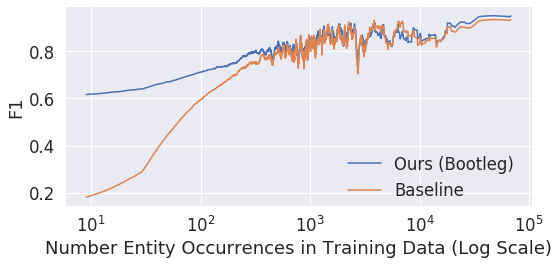

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timeit


sns.set_context("paper")
sns.set(font_scale=1.5)
g = sns.relplot(x="Number Entity Occurrences in Training Data (Log Scale)", y="F1", hue="Model", kind="line", data=res, height=4, aspect=8/4)
g.axes[0][0].set(xscale="log")
leg = g._legend
leg.texts[0].set_text("")
leg.set_bbox_to_anchor([0.7, 0.35])

In [55]:
kg_df.to_pickle("./kg_mod1_pg.pkl")
type_df.to_pickle("./type_mod1_pg.pkl")
entity_df.to_pickle("./ent_mod1_pg.pkl")
# bert_df.to_pickle("./bert_mod1_pg.pkl")
# boot_df.to_pickle("./boot_mod1_pg.pkl")